In [116]:
# Boilerplate imports.
import tensorflow as tf
import numpy as np
from PIL import ImageFilter, Image
#from matplotlib import pylab as plt
import matplotlib.pyplot as plt
import pickle
import tensorflow.contrib.slim as slim
from tensorflow.contrib.framework import get_or_create_global_step

# From https://github.com/tensorflow/models/tree/master/slim.
#from models.slim.nets import inception_v3
from tensorflow.contrib.slim.nets import inception

import os, time

# From our repository.
#from saliency import SaliencyMask
#from saliency import GradientSaliency
#from guided_backprop import GuidedBackprop
#from integrated_gradients import IntegratedGradients
#from occlusion import Occlusion
#import visualization

from iter_mask.defense_new import *

from scipy.misc import imresize

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
gpu = 1

cuda = True if gpu is not None else False
use_mult_gpu = isinstance(gpu, list)
if use_mult_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu).strip('[').strip(']')
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '%d' % gpu

In [118]:
labels = np.loadtxt('synset_words.txt', delimiter='\n', dtype=str)

In [119]:
def denormalize(im):
    return ((im + 1) * 127.5).astype(np.uint8)

def show_image(im, title='', ax=None):
  if ax is None:
    plt.figure()
  plt.axis('off')
  plt.imshow(denormalize(im))
  plt.title(title)

def load_image(file_path, shape = None):
    im = Image.open(file_path)
    if shape is not None:
        im = imresize(im, shape)
    im = np.asarray(im)
    return im / 127.5 - 1.0

In [120]:
#!wget http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
#!tar -xvzf inception_v3_2016_08_28.tar.gz

In [148]:
graph = tf.Graph()
tf_global_step = get_or_create_global_step()

with graph.as_default():
    images = tf.placeholder(tf.float32, shape=(1, 299, 299, 3), name='images')

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(images, is_training=False, num_classes=1001)
        
        # Allocate memory based on need
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True

        # Restore the checkpoint
        sess = tf.Session(config=config, graph=graph)
        saver = tf.train.Saver()
        saver.restore(sess, './inception_v3.ckpt')
        
    # Construct the scalar neuron tensor.
    logits = graph.get_tensor_by_name('InceptionV3/Logits/SpatialSqueeze:0')
    neuron_selector = tf.placeholder(tf.int32, name='neuron_selector')
    y = logits[0][neuron_selector]

    # Construct tensor for predictions.
    prediction = tf.argmax(logits, 1)

INFO:tensorflow:Restoring parameters from ./inception_v3.ckpt


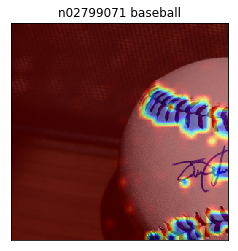

In [161]:
#eps = 16
#adv_dir = '/scratch/local/ssd/ruthfong/tensorflow/cleverhans/adversarial_examples/iter_target_class/eps_%d' % eps
#mask_dir = '/scratch/local/ssd/ruthfong/tensorflow/cleverhans/adversarial_masks/iter_target_class/eps_%d_w_noise/' % eps

image_dir = '/users/ruthfong/tensorflow/cleverhans/examples/nips17_adversarial_competition/dataset/images'
mask_dir = '/scratch/local/ssd/ruthfong/tensorflow/cleverhans/clean_masks/w_noise'
file_name = '517dc655edeaf344'

im = load_image(os.path.join(image_dir, '%s.png' % file_name))
m = np.load(os.path.join(mask_dir, '%s.npy' % file_name))
predicted_label = sess.run(prediction, feed_dict = {images: [im]})[0]

f, ax = plt.subplots(1,1)
ax.imshow(denormalize(im))
ax.imshow(imresize(m, (299,299)), alpha=0.5, cmap='jet')
ax.set_title(labels[predicted_label-1])

ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [128]:
m.shape

(32, 32)

In [112]:
net_type = 'googlenet'

if net_type == 'googlenet':
    batch_shape = (1,299,299,3)
    mask_shape = (32, 32, 1)
    num_classes = 1001
    class_offset = -1
    checkpoint_path = './inception_v3.ckpt'
elif net_type == 'vgg19':
    batch_shape = (1,224,224,3)
    mask_shape = (28, 28, 1)
    num_classes = 1000
    class_offset = 0
    checkpoint_path = './vgg_19.ckpt'
else:
    assert(False)

(graph, sess, tensors_dict, ops_dict) = prepare_graph(
        batch_shape = batch_shape,
        mask_shape = mask_shape,
        num_classes = num_classes,
        checkpoint_path = checkpoint_path,
        learning_rate = 0.1,
        net_type = net_type,
        add_noise = False)

[autoreload of iter_mask.defense_new failed: Traceback (most recent call last):
  File "/users/ruthfong/anaconda2/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ArgumentError: argument --master: conflicting option string(s): --master
]


INFO:tensorflow:Restoring parameters from ./inception_v3.ckpt


In [113]:
softmax = tensors_dict['softmax']
prediction = tensors_dict['prediction']

init_mask_pyramid_ops = ops_dict['init_mask_pyramid_ops']

init_optimizer_op = ops_dict['init_optimizer_op']
clip_mask_op = ops_dict['clip_mask_op']
train = ops_dict['train']

values_dict = {
        'l1_lambda': 0.005,
        'tv_lambda': 0.2,
        'tv_beta': 3,
}

In [114]:
adv_dir = '/scratch/local/ssd/ruthfong/tensorflow/cleverhans/adversarial_examples/iter_target_class/eps_16'

#im = load_image('flute.jpg', shape=batch_shape[1:3])
im = load_image(os.path.join(adv_dir, '8400742ba78ac009.png'))
null_im = blur(im, 10)

n02655020 puffer, pufferfish, blowfish, globefish


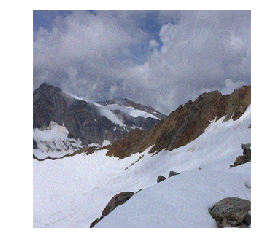

In [115]:
sess.run(ops_dict['no_mask_op'])

top_predicted_class = get_top_predicted_class(im, null_im, tensors_dict, sess)
print labels[top_predicted_class+class_offset]
show_image(im)

In [101]:
#sm = sess.run(softmax, feed_dict = {tensors_dict['images']: [im], tensors_dict['null_images']: [null_im]})
#print labels[np.argsort(sm)+class_offset]

In [102]:
mask_init_op = get_mask_initialization(im, null_im, top_predicted_class,
        softmax, init_mask_pyramid_ops, tensors_dict, sess, init_thres = 1e-2)

init_ops = [mask_init_op, init_optimizer_op]

feed_dict = get_feed_dict(im, null_im, top_predicted_class, tensors_dict, values_dict)

In [103]:
perturbed_top_class = learn_mask(train, prediction, init_ops, clip_mask_op, feed_dict, sess, num_epochs = 300)
print labels[perturbed_top_class+class_offset]

n01491361 tiger shark, Galeocerdo cuvieri


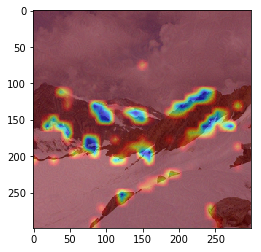

In [104]:
m = sess.run(tensors_dict['mask_up'])
m = np.squeeze(m)

f, ax = plt.subplots(1,1)
ax.imshow(denormalize(im))
ax.imshow(m, alpha=0.5, cmap='jet')
plt.show()

In [93]:
graph = tf.Graph()
tf_global_step = get_or_create_global_step()

with graph.as_default():
    images = tf.placeholder(tf.float32, shape=(1, 299, 299, 3), name='images')
    null_images = tf.placeholder(tf.float32, shape=(1, 299, 299, 3), name='null_images')
    mask = tf.get_variable("mask", shape=(32,32,1), initializer=tf.random_uniform_initializer(0,1))#tf.zeros_initializer())  
    mask_up = tf.image.resize_images(mask,(299,299))
    #noise = tf.random_normal(shape=tf.shape(images), mean=0.0, stddev=0.2, name='noise')
    inputs = images * mask_up + null_images * (1 - mask_up) #+ noise

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(inputs, is_training=False, num_classes=1001)

        # Remove mask variable from list of variables to restore
        model_variables = [v for v in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) if "mask" not in v.name]
        model_variables_w_mask = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        #var_list = None
        
        # Allocate memory based on need
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True

        # Restore the checkpoint
        sess = tf.Session(config=config, graph=graph)
        saver = tf.train.Saver(var_list = model_variables)
        saver.restore(sess, './inception_v3.ckpt')
        
    # Construct the scalar neuron tensor.
    logits = graph.get_tensor_by_name('InceptionV3/Logits/SpatialSqueeze:0')
    neuron_selector = tf.placeholder(tf.int32, name='neuron_selector')
    y = logits[0][neuron_selector]

    # Construct tensor for predictions.
    prediction = tf.argmax(logits, 1)

INFO:tensorflow:Restoring parameters from ./inception_v3.ckpt


In [178]:
with graph.as_default():
    print slim.get_model_variables()

[<tf.Variable 'InceptionV3/Conv2d_1a_3x3/weights:0' shape=(3, 3, 3, 32) dtype=float32_ref>, <tf.Variable 'InceptionV3/Conv2d_1a_3x3/BatchNorm/beta:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'InceptionV3/Conv2d_1a_3x3/BatchNorm/moving_mean:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'InceptionV3/Conv2d_1a_3x3/BatchNorm/moving_variance:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'InceptionV3/Conv2d_2a_3x3/weights:0' shape=(3, 3, 32, 32) dtype=float32_ref>, <tf.Variable 'InceptionV3/Conv2d_2a_3x3/BatchNorm/beta:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'InceptionV3/Conv2d_2a_3x3/BatchNorm/moving_mean:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'InceptionV3/Conv2d_2a_3x3/BatchNorm/moving_variance:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'InceptionV3/Conv2d_2b_3x3/weights:0' shape=(3, 3, 32, 64) dtype=float32_ref>, <tf.Variable 'InceptionV3/Conv2d_2b_3x3/BatchNorm/beta:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'InceptionV3/Conv2d_2b_3x3/BatchNorm/moving_m

In [125]:
clean_dir = '../dataset/images'
#adv_dir = '../sample_attacks/fgsm/output_16'
#adv_dir = '/scratch/local/ssd/ruthfong/tensorflow/cleverhans/adversarial_examples/fgsm/eps_16'
adv_dir = '/scratch/local/ssd/ruthfong/tensorflow/cleverhans/adversarial_examples/iter_target_class/eps_16'

Prediction class: n04590129 window shade (905)


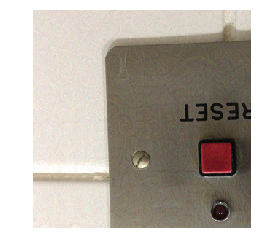

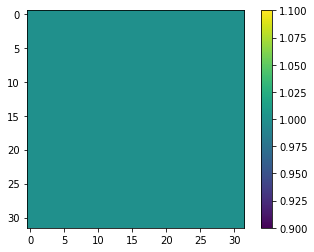

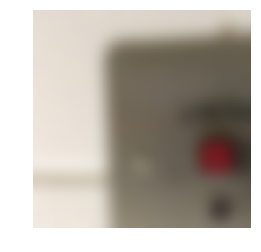

In [171]:
%matplotlib inline

# Load the image
use_clean = False

img_dir = clean_dir if use_clean else adv_dir
im = load_image(os.path.join(img_dir, 'b0bb1ea9bcc45800.png'))
#im = load_image('/Users/ruthfong/tensorflow/saliency/doberman.png')
#with graph.as_default():
#    with sess.as_default():
#        tf.global_variables_initializer().run()

sess.run(mask.initializer)

assign_op = tf.assign(mask, tf.ones_like(mask))
sess.run(assign_op)

#prediction_class = sess.run(prediction, feed_dict = {images: [im]})
(m, comb_img, prediction_class) = sess.run([mask, inputs, prediction], feed_dict = {images: [im], 
                                                                                    null_images: [blur(im, 10)]})
m = np.squeeze(m)
comb_img = comb_img[0]
top_predicted_class = prediction_class[0]

print("Prediction class: %s (%d)" % (labels[top_predicted_class-1], top_predicted_class-1))  # Should be a doberman, class idx = 237

show_image(comb_img)

f, ax = plt.subplots(1,1)
cax = ax.imshow(m)
f.colorbar(cax)
plt.show()

show_image(blur(im, 10))

In [172]:
from scipy.ndimage.filters import gaussian_filter
from scipy.misc import imresize

def create_blurred_circular_mask(mask_shape, radius, center = None, sigma = 10):
    assert(len(mask_shape) == 2)
    if center is None:
        x_center = int(mask_shape[1]/float(2))
        y_center = int(mask_shape[0]/float(2))
    else:
        (x_center, y_center) = center
    y,x = np.ogrid[-y_center:mask_shape[0]-y_center, -x_center:mask_shape[1]-x_center]
    mask = x*x + y*y <= radius*radius
    grid = np.zeros(mask_shape)
    grid[mask] = 1
    if sigma is not None:
        grid = gaussian_filter(grid, sigma)
    return grid

def create_blurred_circular_mask_pyramid(radii = np.arange(0,25,2), mask_shape = (32,32), sigma = 2):
    assert(len(mask_shape) == 2)
    num_masks = len(radii)
    masks = np.zeros((num_masks, mask_shape[0], mask_shape[1], 1))
    for i in range(num_masks):
        masks[i,:,:,0] = create_blurred_circular_mask(mask_shape, radii[i], sigma = sigma)
    return masks

In [173]:
%matplotlib inline

with graph.as_default():
    softmax = end_points['Predictions']

    masks = 1-create_blurred_circular_mask_pyramid()
    scores = np.zeros(len(masks))
    for i in range(len(masks)):
        assign_op = tf.assign(mask, masks[i])
        sess.run(assign_op)
        
        (sm, m, comb_img, prediction_class) = sess.run([softmax, mask, inputs, prediction], 
                                                                 feed_dict={neuron_selector: top_predicted_class, 
                                                                            images: [im], 
                                                                            null_images: [blur(im, 10)]})
        
        sm = np.squeeze(sm)
        m = np.squeeze(m)
        comb_img = comb_img[0]
        prediction_class = prediction_class[0]

        scores[i] = sm[top_predicted_class]
        
        #f, ax = plt.subplots(1,2,figsize=(10,4))
        #ax[0].imshow(((comb_img + 1) * 127.5).astype(np.uint8))
        #ax[0].set_title('%s: %.4f' % (labels[top_predicted_class-1], sm[top_predicted_class]))
        #ax[1].imshow(m)
        #ax[1].set_title('%s: %.4f [%.2f,%.2f]' % (labels[prediction_class-1], sm[prediction_class], 
        #                                             np.min(m), np.max(m)))
        #plt.show()

    thres = 1e-2
    try:
        first_i = np.where(scores < thres)[0][0]
    except:
        first_i = -1

    print first_i, scores[first_i]

6 0.00537011725828


In [174]:
#with graph.as_default():
#    assign_op = tf.assign(mask, tf.ones_like(mask))
#    sess.run(assign_op)

In [175]:
with graph.as_default():
    assign_op = tf.assign(mask, masks[first_i])
    sess.run(assign_op)

<IPython.core.display.Javascript object>


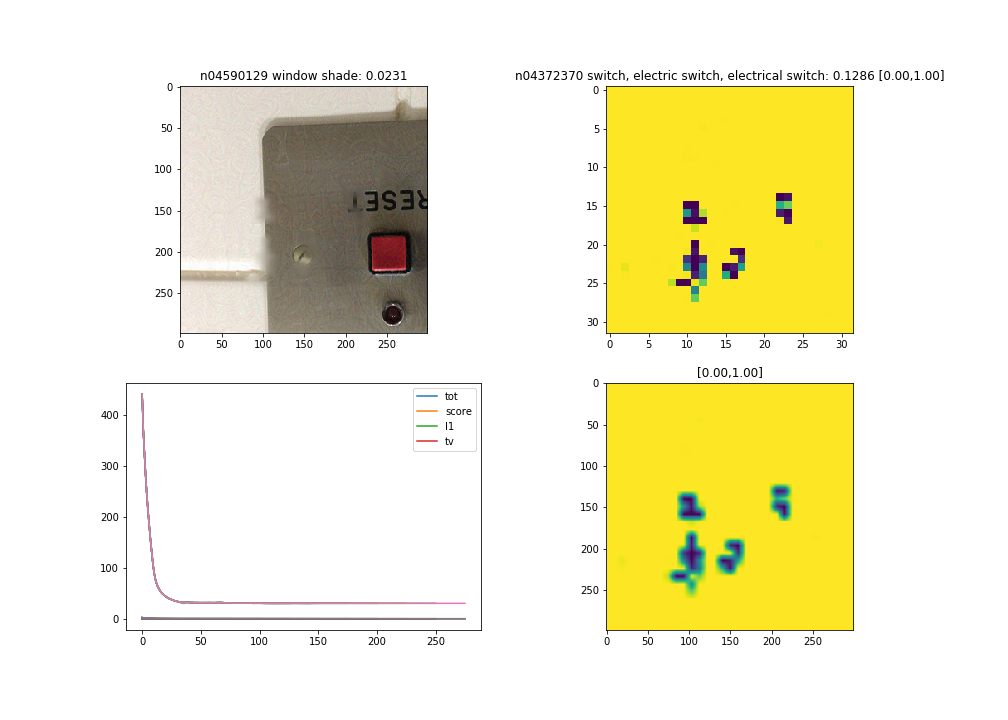

['n04372370 switch, electric switch, electrical switch' 'n03584254 iPod'
 'n04026417 purse' 'n03887697 paper towel' 'n03291819 envelope']
['n04372370 switch, electric switch, electrical switch'
 'n04590129 window shade' 'n04548280 wall clock' 'n03938244 pillow'
 'n04026417 purse']
['n04372370 switch, electric switch, electrical switch'
 'n04590129 window shade' 'n04548280 wall clock' 'n03938244 pillow'
 'n04026417 purse']
['n04372370 switch, electric switch, electrical switch'
 'n04590129 window shade' 'n03938244 pillow' 'n04026417 purse'
 'n04548280 wall clock']
['n04372370 switch, electric switch, electrical switch'
 'n04590129 window shade' 'n03938244 pillow' 'n04026417 purse'
 'n04548280 wall clock']
['n04372370 switch, electric switch, electrical switch'
 'n04590129 window shade' 'n03938244 pillow' 'n04026417 purse'
 'n04548280 wall clock']
['n04372370 switch, electric switch, electrical switch'
 'n04590129 window shade' 'n03938244 pillow' 'n04026417 purse'
 'n04548280 wall clock'

<IPython.core.display.Javascript object>


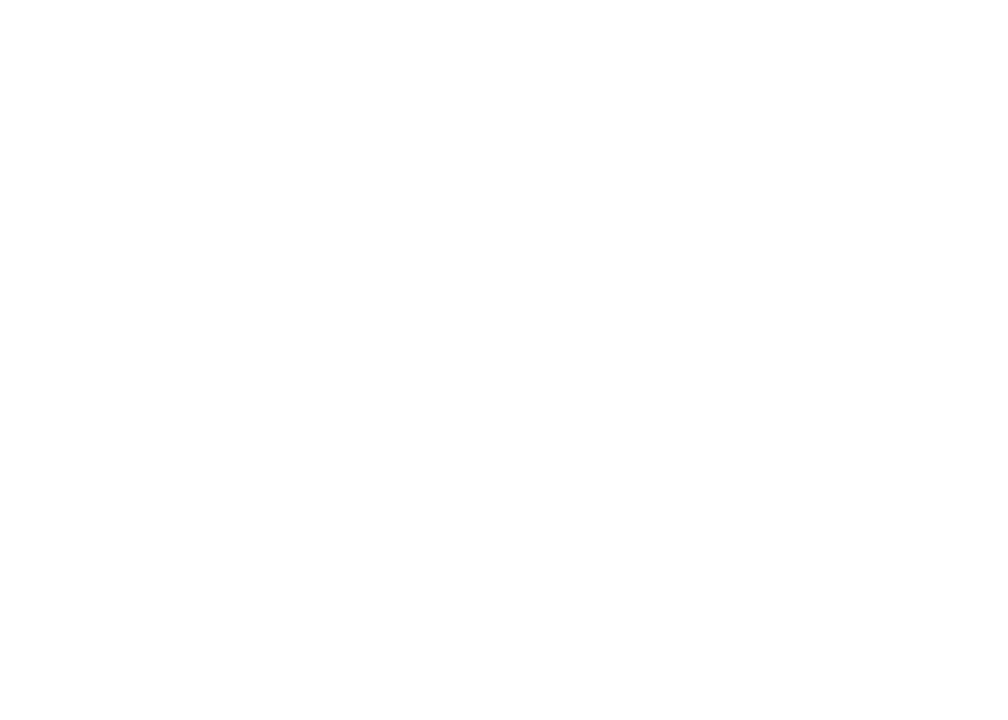

In [176]:
%matplotlib notebook

with graph.as_default():
    l1_lambda = tf.placeholder(tf.float32, name='l1_lambda')
    tv_lambda = tf.placeholder(tf.float32, name='tv_lambda')
    tv_beta = tf.placeholder(tf.float32, name='tv_beta')

    softmax = end_points['Predictions']
    score_loss = softmax[0][neuron_selector]
    l1_loss = tf.reduce_sum(tf.abs(1-mask))
    #def tv_norm(x, beta):
    #    x = x[:,:,0]
    #    dy = tf.reduce_mean(tf.pow(tf.abs(x[:-1,:]-x[1:,:]),beta))
    #    dx = tf.reduce_mean(tf.pow(tf.abs(x[:,:-1]-x[:,1:]),beta))
    #    return dy + dx

    tv_norm_loss = (tf.reduce_mean(tf.pow(tf.abs(mask[:-1,:,0]-mask[1:,:,0]),tv_beta)) 
                    + tf.reduce_mean(tf.pow(tf.abs(mask[:,:-1,0]-mask[:,1:,0]),tv_beta)))
    tot_loss = score_loss + l1_lambda * l1_loss + tv_lambda * tv_norm_loss
    
    optimizer = tf.train.AdamOptimizer(0.1)
    train = optimizer.minimize(tot_loss, var_list=[mask])
          
    optimizer_slots = [
        optimizer.get_slot(mask, name)
        for name in optimizer.get_slot_names()
    ]
        
    optimizer_slots.extend([optimizer._beta1_power, optimizer._beta2_power])
    init_op = tf.variables_initializer(optimizer_slots)
        
    clip_op = tf.assign(mask, tf.clip_by_value(mask, 0, 1))

    sess.run(init_op)

    f, ax = plt.subplots(2,2,figsize=(14, 10))
    plt.ion()
    E = np.zeros((4,300))
    for i in range(300):
        (tot_l, score_l, l1_l, tv_norm_l, sm, m, m_u, comb_img, prediction_class, _) = sess.run([
            tot_loss, score_loss, l1_loss, tv_norm_loss, softmax, mask, mask_up, inputs, prediction,train], 
                                                                 feed_dict={l1_lambda: 0.005,
                                                                            tv_lambda: 0.2, 
                                                                            tv_beta: 3., 
                                                                            neuron_selector: top_predicted_class, 
                                                                            images: [im], 
                                                                            null_images: [blur(im, 10)]})
        sess.run(clip_op)
        
        E[0,i] = tot_l 
        E[1,i] = score_l
        E[2,i] = l1_l
        E[3,i] = tv_norm_l
        
        if i % 25 == 0:
            sm = np.squeeze(sm)
            m = np.squeeze(m)
            m_u = np.squeeze(m_u)
            comb_img = comb_img[0]
            prediction_class = prediction_class[0]
            
            sorted_idx = np.argsort(sm)[::-1]
            print labels[sorted_idx[:5]-1]
            #print E[:,i]
                        
            ax[0][0].imshow(((comb_img + 1) * 127.5).astype(np.uint8))
            ax[0][0].set_title('%s: %.4f' % (labels[top_predicted_class-1], sm[top_predicted_class]))
            cax = ax[0][1].imshow(m)
            ax[0][1].set_title('%s: %.4f [%.2f,%.2f]' % (labels[prediction_class-1], sm[prediction_class], 
                                                         np.min(m), np.max(m)))
            ax[1][0].plot(np.transpose(E[:,:(i+1)]))
            ax[1][0].legend(['tot','score','l1','tv'])
            ax[1][1].imshow(m_u)
            ax[1][1].set_title('[%.2f,%.2f]' % (np.min(m_u), np.max(m_u)))
            #f.colorbar(cax)
            f.canvas.draw()
            time.sleep(1e-2)

In [267]:
with graph.as_default():
    print tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

[<tf.Variable 'mask:0' shape=(32, 32, 1) dtype=float32_ref>, <tf.Variable 'InceptionV3/Conv2d_1a_3x3/weights:0' shape=(3, 3, 3, 32) dtype=float32_ref>, <tf.Variable 'InceptionV3/Conv2d_1a_3x3/BatchNorm/beta:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'InceptionV3/Conv2d_2a_3x3/weights:0' shape=(3, 3, 32, 32) dtype=float32_ref>, <tf.Variable 'InceptionV3/Conv2d_2a_3x3/BatchNorm/beta:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'InceptionV3/Conv2d_2b_3x3/weights:0' shape=(3, 3, 32, 64) dtype=float32_ref>, <tf.Variable 'InceptionV3/Conv2d_2b_3x3/BatchNorm/beta:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'InceptionV3/Conv2d_3b_1x1/weights:0' shape=(1, 1, 64, 80) dtype=float32_ref>, <tf.Variable 'InceptionV3/Conv2d_3b_1x1/BatchNorm/beta:0' shape=(80,) dtype=float32_ref>, <tf.Variable 'InceptionV3/Conv2d_4a_3x3/weights:0' shape=(3, 3, 80, 192) dtype=float32_ref>, <tf.Variable 'InceptionV3/Conv2d_4a_3x3/BatchNorm/beta:0' shape=(192,) dtype=float32_ref>, <tf.Variable 'InceptionV3/Mi

In [58]:
for op in graph.get_operations():
    if op.type == 'Placeholder':
        print op.name

images
null_images
Placeholder
l1_lambda
tv_lambda
tv_beta


In [ ]:
with graph.as_default():
    global_step = tf.train.get_global_step()
    

In [81]:
with graph.as_default():
    gradients_node = tf.gradients(y, images)[0]

In [87]:
with graph.as_default():
    mask = tf.get_variable("mask", shape=(32,32,1), initializer=tf.zeros_initializer())

In [88]:
with graph.as_default():
    mask_upsampled=tf.image.resize_images(mask,(299,299))

In [89]:
with graph.as_default():
    with sess.as_default():
        tf.global_variables_initializer().run()

In [90]:
mask_upsampled

<tf.Tensor 'Squeeze:0' shape=(299, 299, 1) dtype=float32>

In [91]:
null_im = blur(im,10)

In [92]:
comb_im = mask_upsampled * im + (1 - mask_upsampled) * null_im

In [97]:
(grad, pred) = sess.run([gradients_node, prediction], feed_dict = {images: [comb_im.eval(session=sess)], 
                                                             neuron_selector: prediction_class})

In [103]:
mask = tf.clip_by_value(mask,0,1)

In [127]:
for n in graph.as_graph_def().node:
    print n.name

x
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal/shape
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal/mean
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal/stddev
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal/TruncatedNormal
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal/mul
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal
InceptionV3/Conv2d_1a_3x3/weights
InceptionV3/Conv2d_1a_3x3/weights/Assign
InceptionV3/Conv2d_1a_3x3/weights/read
InceptionV3/InceptionV3/Conv2d_1a_3x3/kernel/Regularizer/l2_regularizer/scale
InceptionV3/InceptionV3/Conv2d_1a_3x3/kernel/Regularizer/l2_regularizer/L2Loss
InceptionV3/InceptionV3/Conv2d_1a_3x3/kernel/Regularizer/l2_regularizer
InceptionV3/InceptionV3/Conv2d_1a_3x3/convolution/Shape
InceptionV3/InceptionV3/Conv2d_1a_3x3/convolution/dilation_rate
InceptionV3/InceptionV3/Conv2d_1a_3x3/convolution
InceptionV3/Conv2d_1a_3x3/BatchNorm/beta/Initializer/zeros
InceptionV

In [104]:
for op in graph.get_operations():
    print str(op.name)

Placeholder
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal/shape
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal/mean
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal/stddev
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal/TruncatedNormal
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal/mul
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal
InceptionV3/Conv2d_1a_3x3/weights
InceptionV3/Conv2d_1a_3x3/weights/Assign
InceptionV3/Conv2d_1a_3x3/weights/read
InceptionV3/InceptionV3/Conv2d_1a_3x3/kernel/Regularizer/l2_regularizer/scale
InceptionV3/InceptionV3/Conv2d_1a_3x3/kernel/Regularizer/l2_regularizer/L2Loss
InceptionV3/InceptionV3/Conv2d_1a_3x3/kernel/Regularizer/l2_regularizer
InceptionV3/InceptionV3/Conv2d_1a_3x3/convolution/Shape
InceptionV3/InceptionV3/Conv2d_1a_3x3/convolution/dilation_rate
InceptionV3/InceptionV3/Conv2d_1a_3x3/convolution
InceptionV3/Conv2d_1a_3x3/BatchNorm/beta/Initializer/zeros
